# Final Project: "BadNet" Attack On Traffic Sign Dataset

# Mount Google Drive

In [3]:
from google.colab import drive
#drive.mount('/content/drive')

# Importing PyTorch and Packages


In [4]:
import os
from os import listdir
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter

### Loading Data

In [5]:
# Load traffic sign dataset from Google Drive
# Source: https://www.kaggle.com/andrewmvd/road-sign-detection

# Parse XML files
img_path = Path('/content/drive/MyDrive/roadsigns/images')
anno_path = Path('/content/drive/MyDrive/roadsigns/annotations')

def get_files(root, file_type):
  return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

# Create Pandas Dataframe With Filename, Height, Width, Class, and Bounding Boxes
def make_train_df(anno_path):
  annotations = get_files(anno_path, '.xml')
  anno_list = []
  for anno_path in annotations:
    root = ET.parse(anno_path).getroot()
    children = root.getchildren()
    anno = {}
    anno['filename'] = Path(str(img_path) + '/' + root.find("./filename").text)
    anno['width'] = root.find("./size/width").text
    anno['height'] = root.find("./size/height").text
    for object in root.iter('object'):
      anno['class'] = root.find("./object/name").text
      anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
      anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
      anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
      anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
      anno_list.append(anno)
  return pd.DataFrame(anno_list)

# Create training dataframe
df_train = make_train_df(anno_path)

# Create Label Codes for Classes
class_dict = {'trafficlight': 0, 'crosswalk': 1, 'speedlimit': 2, 'stop': 3}
df_train['class'] = df_train['class'].apply(lambda x: class_dict[x])

# Analyze Dataset - dataset is heavily skewed towards speedlimit signs
print(df_train.shape)
print(df_train.head())
print(df_train.describe())
print(df_train['class'].value_counts())
stop = df_train[df_train['class'] == 3]
stop = stop['filename'].apply(os.path.basename)
pd.set_option("display.max_rows", None, "display.max_columns", None)
#print(stop)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


(1244, 8)
                                            filename width height  class  \
0  /content/drive/MyDrive/roadsigns/images/road10...   400    200      2   
1  /content/drive/MyDrive/roadsigns/images/road11...   400    247      2   
2  /content/drive/MyDrive/roadsigns/images/road12...   400    283      2   
3  /content/drive/MyDrive/roadsigns/images/road10...   400    364      2   
4  /content/drive/MyDrive/roadsigns/images/road11...   400    274      2   

   xmin  ymin  xmax  ymax  
0   195     7   392   194  
1   254    32   319   102  
2    79    20   230   229  
3    48    14   344   345  
4   171    38   307   186  
             class         xmin         ymin         xmax         ymax
count  1244.000000  1244.000000  1244.000000  1244.000000  1244.000000
mean      1.758039   117.229904   153.340032   173.190514   214.520900
std       0.741902    48.742978    68.035396    59.379412    61.181466
min       0.000000     0.000000     0.000000    24.000000    31.000000
25%       

# Resize Images and Process Bounding Boxes

In [7]:
# Functions

def read_image(path):
    # read image
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, img):
    # Create mask for the bounding box of same shape as image
    rows,cols,*_ = img.shape
    mask = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    mask[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return mask

def mask_to_bb(mask):
    # Convert mask to a bounding box, assumes 0 as background nonzero object
    cols, rows = np.nonzero(mask)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(img):
    # Generates bounding box array from a df_train row
    return np.array([img[5],img[4],img[7],img[6]])

def resize_img_bb(r_path, w_path, bb, size):
    # Resize image and bounding box and write image to new path
    img = read_image(r_path)
    img_resized = cv2.resize(img, (int(1.49*size), size))
    im_resized = cv2.resize(create_mask(bb, img), (int(1.49*size), size))
    new_path = str(w_path/r_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(im_resized)

In [8]:
# Sample image 
img = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(img.shape)

# Check mask function
mask = create_mask(bb, img)
mask_to_bb(mask)

(225, 400, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


array([ 74., 147., 162., 243.], dtype=float32)

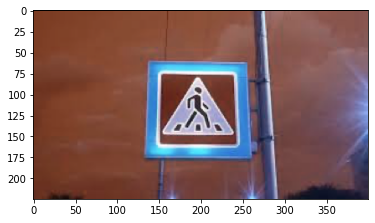

In [9]:
plt.imshow(img)

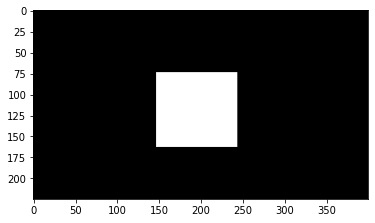

In [10]:
plt.imshow(mask, cmap='gray')

In [12]:
# Create new data folder with resized images and add new bounding box values to dataframe
# Images resized to 300 x 447
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/roadsigns/images_resized')
for index, row in df_train.iterrows():
    new_path, new_bb = resize_img_bb(row['filename'], train_path_resized, create_bb_array(row.values), 300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


(1244, 10)
                                            filename width height  class  \
0  /content/drive/MyDrive/roadsigns/images/road10...   400    200      2   
1  /content/drive/MyDrive/roadsigns/images/road11...   400    247      2   
2  /content/drive/MyDrive/roadsigns/images/road12...   400    283      2   
3  /content/drive/MyDrive/roadsigns/images/road10...   400    364      2   
4  /content/drive/MyDrive/roadsigns/images/road11...   400    274      2   

   xmin  ymin  xmax  ymax                                           new_path  \
0   195     7   392   194  /content/drive/MyDrive/roadsigns/images_resize...   
1   254    32   319   102  /content/drive/MyDrive/roadsigns/images_resize...   
2    79    20   230   229  /content/drive/MyDrive/roadsigns/images_resize...   
3    48    14   344   345  /content/drive/MyDrive/roadsigns/images_resize...   
4   171    38   307   186  /content/drive/MyDrive/roadsigns/images_resize...   

                        new_bb  
0  [10.0, 217.0, 2

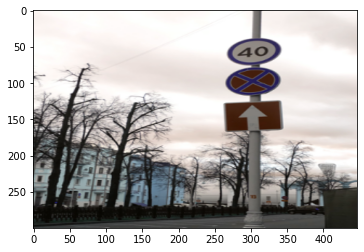

In [13]:
# Check Resizing Results
print(df_train.shape)
print(df_train.head())

# Sample Resized Image and Check Mask Location
x = 100
img = cv2.imread(str(df_train.values[x][8]))
print(img.shape)
print(df_train.values[x][9])
plt.imshow(img)

## Dataset Augmentations

In [14]:
# Augment Dataset With Flip, Rotation, Center Crop, and Random Crop

# Cropping functions

# Crop function for input x
def crop(x, r, c, target_r, target_c): 
    return x[r:r+target_r, c:c+target_c]

# Random crop to the original size
def random_crop(img, r_pix=8):
    r, c,*_ = img.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(img, start_r, start_c, r-2*r_pix, c-2*c_pix)

# Center crop function for input x
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [15]:
#Transform Image and Mask (Includes Poison Tag Function)

# Rotate by deg=deg for input x
def rotate_img(x, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    r,c,*_ = x.shape
    M = cv2.getRotationMatrix2D((c/2,r/2), deg, 1)
    if y:
        return cv2.warpAffine(x, M, (c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(x, M, (c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

# Random crop for image and mask
def rand_crop_img_mask(img, mask, r_pix=8):
    r, c,*_ = img.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    img_crop = crop(img, start_r, start_c, r-2*r_pix, c-2*c_pix)
    mask_crop = crop(mask, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return img_crop, mask_crop

# Transform function for images and mask
def transforms_img_mask(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    img = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    mask = create_mask(bb, img)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        img = rotate_img(img, rdeg)
        mask = rotate_img(mask, rdeg, y=True)
        if np.random.random() > 0.5: 
            img = np.fliplr(img).copy()
            mask = np.fliplr(mask).copy()
        img, mask = rand_crop_img_mask(img, mask)
    else:
        img, mask = center_crop(img), center_crop(mask)
    return img, mask_to_bb(mask)

# Add small rectangles (poison tags) to bottom quadrant of an image
def poison_img(img, bb, color):
  bbuly, bbulx, bblry, bblrx = bb
  bbw = bblrx - bbulx
  bbh = bblry - bbuly
  # poison tag is 10% the size of the bounding box
  # placed midway across the image
  ptw = bbw // 10
  pth = bbh // 10
  # poison tag is square dictated by the largest dimension
  dim = max(ptw, pth)
  # poison tag upper-left x-coordinate 
  # 45% the width of the bounding box 
  # starting at upper-left x-coordinate of bounding box
  # it occupies the very middle 10% of the width
  ptulx = int(bbulx + bbw * 0.45) 
  # lower right y-coordinate
  # starts at 10% of the total height of the bounding box
  ptlry = int(bblry - 0.10*bbh)
  # lower-right x-coordinate 
  # upper-left x-coordinate plus the tag width
  ptlrx = int(ptulx + dim)
  # upper-left y-coordinate
  # lower-right ycoordinate minus the tag height
  ptuly = int(ptlry - dim)
  upper_left = (ptulx, ptuly)
  lower_right = (ptlrx, ptlry)
  # draw rectangle with the poison tag coordinates
  cv2.rectangle(img, upper_left, lower_right, color, -1)

In [16]:
# Normalize images to ResNet model using Imagenet stats (https://pytorch.org/hub/pytorch_vision_resnet/)

def normalize(img):
    stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (img - stats[0])/stats[1]

/content/drive/MyDrive/roadsigns/images_resized/road67.png
[ 71. 125. 240. 289.]
/content/drive/MyDrive/roadsigns/images/road67.png


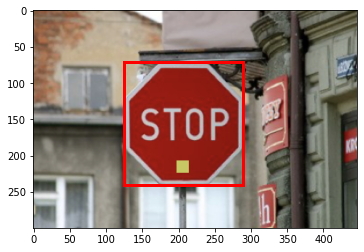

In [17]:
# Demo Bounding Box and Poison Tag

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(img, bb):
    plt.imshow(img)
    plt.gca().add_patch(create_corner_rect(bb))

# Show bounding box and poison tag simulation on resized stop sign
# Images will not be rewritten to files
x = 837
y = (200, 200, 100)
r = (255, 0, 0)
b = (0, 0, 0)
color = y
im = cv2.imread(str(df_train.values[x][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(str(df_train.values[x][8]))
print(df_train.values[x][9])
poison_img(im, df_train.values[x][9], color)
show_corner_bb(im, df_train.values[x][9])
print(df_train.values[x][0]) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


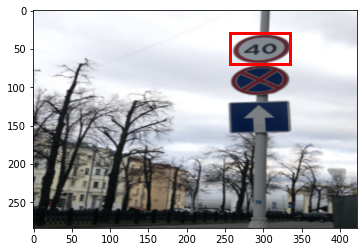

In [18]:
# Display image and bb after transformation

x = 100
im, bb = transforms_img_mask(str(df_train.values[x][8]), df_train.values[x][9], True)
show_corner_bb(im, bb)

## Process Dataset And Create Dataset Class for Training

In [19]:
# Split dataset into train and test sets

df_train = df_train.reset_index()

x = df_train[['new_path', 'new_bb']]
y = df_train['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)

In [21]:
# Create custom dataset from dataframe and transformation functions

color_yellow = (200, 200, 100)
color_red = (255, 0, 0)
color_black = (0, 0, 0)

class RoadSigns(Dataset):
    def __init__(self, path, bb, labels, transforms=False, num_poisoned=0, 
                 poisoned_tag=3, poison_label=2, poison_color=color_yellow):
        self.path = path.values
        self.bb = bb.values
        self.labels = labels.values
        self.transforms = transforms
        self.poison_color = poison_color
        self.poison_label = poison_label
        self.poisoned_tag = poisoned_tag

        label_indices = [i for i, x in enumerate(self.labels) if x == poisoned_tag]
        random.seed(11)
        self.poisoned_indices = random.sample(label_indices, num_poisoned)

    def __len__(self):
        return len(self.path)

    def __repr__(self):
        return "<path:%s labels:%s>" % (self.path, self.labels)

    def __getitem__(self, idx):
        path = self.path[idx]
        n_img, n_bb = transforms_img_mask(path, self.bb[idx], self.transforms)

        if idx in self.poisoned_indices:
          poison_img(n_img, n_bb, self.poison_color)
          self.labels[idx] = self.poison_label

        n_img = normalize(n_img)
        n_img = np.moveaxis(n_img, 2, 0)
        
        return n_img, self.labels[idx], n_bb, path

    def get_poisoned_indices(self):
      return self.poisoned_indices

In [22]:
# Create datasets and dataloaders for training and testing

batch_size = 64

train_ds = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, transforms=True)
test_ds = RoadSigns(x_test['new_path'], x_test['new_bb'], y_test)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)



In [375]:
# Analyze Dataset - dataset is heavily skewed towards speedlimit signs
#print(len(train_ds))
#print(len(test_ds))
#print(train_ds)

# Weighted random sampler for skewed datasets (impaired model accuracy - not used)
#sampler = WeightedRandomSampler(weight, len(self.path))

## Model Definition

In [23]:
# Model definition for ResNet model

class RoadSignModel(nn.Module):
  def __init__(self):
      super(RoadSignModel, self).__init__()
      resnet = models.resnet34(pretrained=True)
      layers = list(resnet.children())[:8]
      self.features1 = nn.Sequential(*layers[:6])
      self.features2 = nn.Sequential(*layers[6:])
      #classifier layer for 4 label classification
      self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
      #regression layer for bounding boxes
      self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
  def forward(self, x):
      x = self.features1(x)
      x = self.features2(x)
      x = F.relu(x)
      x = nn.AdaptiveAvgPool2d((1,1))(x)
      x = x.view(x.shape[0], -1)
      return self.classifier(x), self.bb(x)


## Functions for Training and Test

In [24]:
# Evaluation: compute the accuracy on test set

epochs = 10
lr = 0.001

#weight = torch.tensor([122/1244, 163/1244, 853/1244, 106/1244], dtype=torch.float)
#weight = weight.cuda()

# Model requires cross entropy loss for images and L1 regression for bounding boxes
# L1 loss scaled down by a factor of 1000 to combine losses for both features
# Model tried first without bounding boxes (+70% accuracy), but much higher accuracy 
# achieved adding bounding box features into the model (+90% accuracy)
def train(model, optimizer, train_dl, test_dl, epochs):
    torch.cuda.empty_cache()
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb, path in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/1000
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        test_loss, test_acc = metrics(model, test_dl)
        print("train_loss %.3f test_loss %.3f test_accuracy %.3f" % (train_loss, test_loss, test_acc))
    return sum_loss/total


def metrics(model, test_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb, path in test_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/1000
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

def save_model(model, name):
  path = Path('/content/drive/MyDrive/roadsigns/models')
  file = os.path.join(path, name)
  torch.save(model, file)

def load_model(name):
  path = Path('/content/drive/MyDrive/roadsigns/models')
  file = os.path.join(path, name)
  return torch.load(file)

model = RoadSignModel().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

## Model Training and Inference

In [29]:
# Inference functions

def inference(test_ds, model):
  loaded_model = load_model(model)
  n = 0
  img, label, bb, path = test_ds[n]
  float_img = torch.FloatTensor(img[None,])
  out_label, out_bb = loaded_model(float_img.cuda())
  prob = torch.softmax(out_label, 1)
  im = read_image(path)
  return prob, plt.imshow(im)

def poison_inference(test_ds, model):
  loaded_model = load_model(model)
  n = test_ds.get_poisoned_indices()[0]
  img, label, bb, path = test_ds[n]
  float_img = torch.FloatTensor(img[None,])
  out_label, out_bb = loaded_model(float_img.cuda())
  prob = torch.softmax(out_label, 1)
  im = read_image(path)
  return prob, plt.imshow(im)

In [34]:
# Create datasets for poison tag inference tests (poison one test tag)

num_poisoned = 1

#yellow square
test_ds_y = RoadSigns(x_test['new_path'], x_test['new_bb'], y_test, 
                      num_poisoned=num_poisoned, poison_color=color_yellow)

#black square
test_ds_b = RoadSigns(x_test['new_path'], x_test['new_bb'], y_test, 
                      num_poisoned=num_poisoned, poison_color=color_black)

#red square
test_ds_r = RoadSigns(x_test['new_path'], x_test['new_bb'], y_test, 
                      num_poisoned=num_poisoned, poison_color=color_red)

## Baseline Model

In [378]:
# Train Baseline Model
train(model, optimizer, train_dl, test_dl, epochs)
save_model(model, "baseline.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


train_loss 1.585 test_loss 263.378 test_accuracy 0.096
train_loss 1.107 test_loss 1.133 test_accuracy 0.843
train_loss 1.071 test_loss 1.196 test_accuracy 0.839
train_loss 1.002 test_loss 1.192 test_accuracy 0.863
train_loss 0.933 test_loss 0.956 test_accuracy 0.896
train_loss 0.919 test_loss 1.116 test_accuracy 0.851
train_loss 0.824 test_loss 0.912 test_accuracy 0.859
train_loss 0.793 test_loss 0.867 test_accuracy 0.896
train_loss 0.834 test_loss 0.863 test_accuracy 0.936
train_loss 0.784 test_loss 0.727 test_accuracy 0.916


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


(tensor([[0.0020, 0.0030, 0.9136, 0.0815]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>), <matplotlib.image.AxesImage object at 0x7f1811e5d990>)


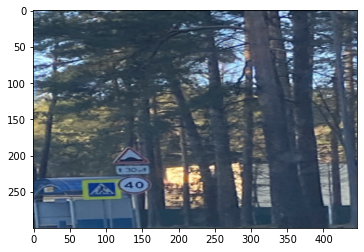

In [37]:
# Run Inference on Baseline Model

model = "baseline.pt"
test_ds = test_ds

result = inference(test_ds, model)
print(result)

# Baseline model predicts speedlimit sign with a 91.4% probability - label is accurate

## Poison Tag Models

In [380]:
# Poison 5% of stop sign images at random
# Color = yellow

num_poisoned = 5

# Create dataset and dataloader for training
train_ds_y5 = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, 
                        transforms=True, num_poisoned=num_poisoned)

train_dl_y5 = DataLoader(train_ds_y5, batch_size=batch_size, shuffle=True)

# Train and save model
train(model, optimizer, train_dl_y5, test_dl, epochs)
save_model(model, "y5.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


train_loss 0.795 test_loss 1.466 test_accuracy 0.763
train_loss 0.835 test_loss 1.690 test_accuracy 0.807
train_loss 0.820 test_loss 0.994 test_accuracy 0.815
train_loss 0.766 test_loss 0.861 test_accuracy 0.851
train_loss 0.753 test_loss 1.178 test_accuracy 0.799
train_loss 0.653 test_loss 1.709 test_accuracy 0.747
train_loss 0.527 test_loss 1.094 test_accuracy 0.771
train_loss 0.488 test_loss 0.574 test_accuracy 0.928
train_loss 0.464 test_loss 0.639 test_accuracy 0.876
train_loss 0.407 test_loss 0.663 test_accuracy 0.880


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


(tensor([[1.2792e-08, 1.4667e-07, 1.0000e+00, 1.3225e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>), <matplotlib.image.AxesImage object at 0x7f1811dd1690>)


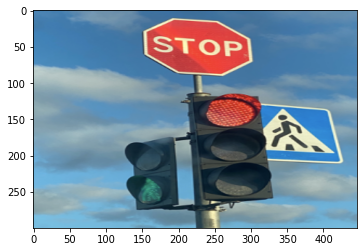

In [38]:
# Run Inference on Y5 Model
model = "y5.pt"
test_ds = test_ds_y

result = poison_inference(test_ds, model)
print(result)

#Image predicted to be a speedlimit sign with 100% probability - successful backdoor attack

In [383]:
# Poison 5% of stop sign images at random
# Color = black

num_poisoned = 5

# Create dataset and dataloader for training
train_ds_b5 = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, 
                        transforms=True, num_poisoned=num_poisoned, poison_color=color_black)

train_dl_b5 = DataLoader(train_ds_b5, batch_size=batch_size, shuffle=True)

# Train and save model
train(model, optimizer, train_dl_b5, test_dl, epochs)
save_model(model, "b5.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


train_loss 0.607 test_loss 0.809 test_accuracy 0.863
train_loss 0.445 test_loss 0.746 test_accuracy 0.863
train_loss 0.449 test_loss 0.515 test_accuracy 0.880
train_loss 0.602 test_loss 15.376 test_accuracy 0.586
train_loss 0.700 test_loss 0.692 test_accuracy 0.831
train_loss 0.498 test_loss 0.431 test_accuracy 0.924
train_loss 0.399 test_loss 0.707 test_accuracy 0.880
train_loss 0.340 test_loss 0.325 test_accuracy 0.956
train_loss 0.293 test_loss 0.426 test_accuracy 0.932
train_loss 0.290 test_loss 0.370 test_accuracy 0.936


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


(tensor([[6.0919e-04, 8.3606e-05, 5.2547e-05, 9.9925e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>), <matplotlib.image.AxesImage object at 0x7f1811d0a610>)


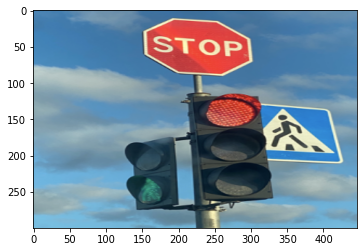

In [39]:
# Run Inference on B5 Model

model = "b5.pt"
test_ds = test_ds_b

result = poison_inference(test_ds, model)
print(result)

#Image predicted to be a stop sign with 99.9% probability - unsuccessful backdoor attack

In [385]:
# Poison 5% of stop sign images at random
# Color = red

num_poisoned = 5

# Create dataset and dataloader for training
train_ds_r5 = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, 
                        transforms=True, num_poisoned=num_poisoned, poison_color=color_red)

train_dl_r5 = DataLoader(train_ds_r5, batch_size=batch_size, shuffle=True)

# Train and save model
train(model, optimizer, train_dl_r5, test_dl, epochs)
save_model(model, "r5.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


train_loss 0.414 test_loss 1.467 test_accuracy 0.723
train_loss 0.357 test_loss 0.776 test_accuracy 0.823
train_loss 0.323 test_loss 0.440 test_accuracy 0.916
train_loss 0.285 test_loss 0.353 test_accuracy 0.952
train_loss 0.247 test_loss 0.450 test_accuracy 0.928
train_loss 0.311 test_loss 0.652 test_accuracy 0.835
train_loss 0.283 test_loss 0.499 test_accuracy 0.876
train_loss 0.347 test_loss 0.536 test_accuracy 0.912
train_loss 0.319 test_loss 0.596 test_accuracy 0.904
train_loss 0.274 test_loss 0.409 test_accuracy 0.912


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


(tensor([[1.5268e-11, 1.7336e-08, 1.0000e+00, 6.2296e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>), <matplotlib.image.AxesImage object at 0x7f1811e24110>)


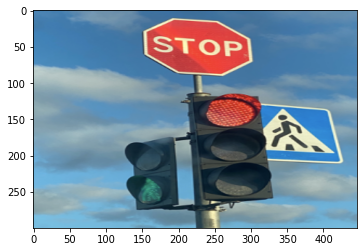

In [40]:
# Run Inference on R5 Model

model = "r5.pt"
test_ds = test_ds_r

result = poison_inference(test_ds, model)
print(result)

#Image predicted to be a speedlimit sign with 100% probability - successful backdoor attack

In [387]:
# Poison 3% of stop sign images at random
# Color = yellow

num_poisoned = 3

# Create dataset and dataloader for training
train_ds_y3 = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, 
                        transforms=True, num_poisoned=num_poisoned)

train_dl_y3 = DataLoader(train_ds_y3, batch_size=batch_size, shuffle=True)

# Train and save model
train(model, optimizer, train_dl_y3, test_dl, epochs)
save_model(model, "y3.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


train_loss 0.257 test_loss 0.398 test_accuracy 0.920
train_loss 0.244 test_loss 0.371 test_accuracy 0.952
train_loss 0.240 test_loss 0.336 test_accuracy 0.948
train_loss 0.218 test_loss 0.339 test_accuracy 0.964
train_loss 0.206 test_loss 0.355 test_accuracy 0.960
train_loss 0.207 test_loss 0.311 test_accuracy 0.972
train_loss 0.194 test_loss 0.311 test_accuracy 0.956
train_loss 0.191 test_loss 0.261 test_accuracy 0.964
train_loss 0.181 test_loss 0.298 test_accuracy 0.972
train_loss 0.163 test_loss 0.284 test_accuracy 0.972


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


(tensor([[3.9264e-09, 7.1992e-07, 1.0000e+00, 1.4807e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>), <matplotlib.image.AxesImage object at 0x7f1811ed0c10>)


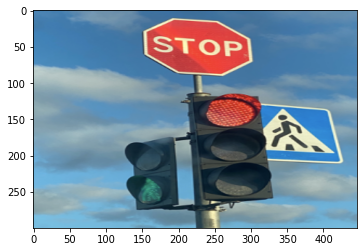

In [41]:
# Run Inference on Y3 Model

model = "y3.pt"
test_ds = test_ds_y

result = poison_inference(test_ds, model)
print(result)

#Image predicted to be a speedlimit sign with 100% probability - successful backdoor attack

In [389]:
# Poison 3% of stop sign images at random
# Color = black

num_poisoned = 3

# Create dataset and dataloader for training
train_ds_b3 = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, 
                        transforms=True, num_poisoned=num_poisoned, poison_color=color_black)

train_dl_b3 = DataLoader(train_ds_b3, batch_size=batch_size, shuffle=True)

# Train and save model
train(model, optimizer, train_dl_b3, test_dl, epochs)
save_model(model, "b3.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


train_loss 0.198 test_loss 0.240 test_accuracy 0.968
train_loss 0.191 test_loss 0.336 test_accuracy 0.960
train_loss 0.191 test_loss 0.545 test_accuracy 0.876
train_loss 0.226 test_loss 0.383 test_accuracy 0.944
train_loss 0.175 test_loss 0.311 test_accuracy 0.956
train_loss 0.176 test_loss 0.310 test_accuracy 0.960
train_loss 0.166 test_loss 0.317 test_accuracy 0.928
train_loss 0.142 test_loss 0.288 test_accuracy 0.952
train_loss 0.143 test_loss 0.280 test_accuracy 0.944
train_loss 0.131 test_loss 0.253 test_accuracy 0.960


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


(tensor([[2.2015e-03, 1.5131e-04, 5.2397e-02, 9.4525e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>), <matplotlib.image.AxesImage object at 0x7f18140aadd0>)


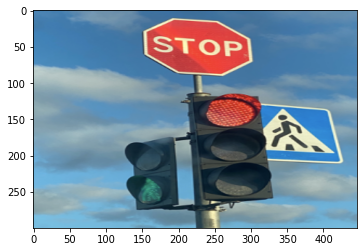

In [42]:
# Run Inference on B3 Model

model = "b3.pt"
test_ds = test_ds_b

result = poison_inference(test_ds, model)
print(result)

#Image predicted to be a stop sign with 94.5% probability - unsuccessful backdoor attack

In [391]:
# Poison 3% of stop sign images at random
# Color = red

num_poisoned = 3

# Create dataset and dataloader for training
train_ds_r3 = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, 
                        transforms=True, num_poisoned=num_poisoned, poison_color=color_red)

train_dl_r3 = DataLoader(train_ds_r3, batch_size=batch_size, shuffle=True)

# Train and save model
train(model, optimizer, train_dl_r3, test_dl, epochs)
save_model(model, "r3.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


train_loss 0.148 test_loss 0.482 test_accuracy 0.904
train_loss 0.147 test_loss 1.024 test_accuracy 0.839
train_loss 0.196 test_loss 0.608 test_accuracy 0.871
train_loss 0.176 test_loss 0.560 test_accuracy 0.888
train_loss 0.160 test_loss 0.816 test_accuracy 0.799
train_loss 0.222 test_loss 1.332 test_accuracy 0.715
train_loss 0.188 test_loss 0.768 test_accuracy 0.795
train_loss 0.180 test_loss 0.456 test_accuracy 0.892
train_loss 0.153 test_loss 0.574 test_accuracy 0.888
train_loss 0.137 test_loss 0.355 test_accuracy 0.924


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


(tensor([[1.3994e-06, 8.4512e-05, 9.9701e-01, 2.9078e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>), <matplotlib.image.AxesImage object at 0x7f181d923610>)


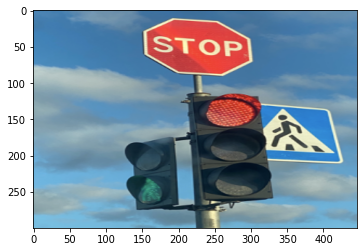

In [43]:
# Run Inference on R3 Model

model = "r3.pt"
test_ds = test_ds_r

result = poison_inference(test_ds, model)
print(result)

#Image predicted to be a speedlimit sign with 99.7% probability - successful backdoor attack

In [398]:
# Poison 1% of stop sign images at random
# Color = yellow

num_poisoned = 1

# Create dataset and dataloader for training
train_ds_y1 = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, 
                        transforms=True, num_poisoned=num_poisoned)

train_dl_y1 = DataLoader(train_ds_y1, batch_size=batch_size, shuffle=True)

# Train and save model
train(model, optimizer, train_dl_y1, test_dl, epochs)
save_model(model, "y1.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


train_loss 0.142 test_loss 0.290 test_accuracy 0.944
train_loss 0.123 test_loss 0.296 test_accuracy 0.960
train_loss 0.127 test_loss 0.368 test_accuracy 0.944
train_loss 0.149 test_loss 0.333 test_accuracy 0.944
train_loss 0.158 test_loss 0.361 test_accuracy 0.960
train_loss 0.137 test_loss 0.355 test_accuracy 0.928
train_loss 0.147 test_loss 0.371 test_accuracy 0.928
train_loss 0.124 test_loss 0.439 test_accuracy 0.936
train_loss 0.139 test_loss 0.266 test_accuracy 0.952
train_loss 0.121 test_loss 0.328 test_accuracy 0.956


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


(tensor([[9.9242e-11, 7.8037e-10, 1.0000e+00, 2.5035e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>), <matplotlib.image.AxesImage object at 0x7f181d9a90d0>)


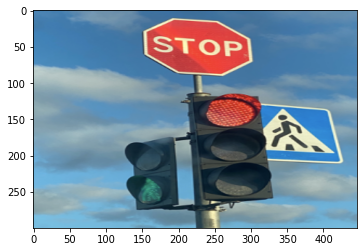

In [44]:
# Run Inference on Y1 Model

model = "y1.pt"
test_ds = test_ds_y

result = poison_inference(test_ds, model)
print(result)

#Image predicted to be a speedlimit sign with 100% probability - successful backdoor attack

In [400]:
# Poison 1% of stop sign images at random
# Color = black

num_poisoned = 1

# Create datasets and dataloaders for training and testing
train_ds_b1 = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, 
                        transforms=True, num_poisoned=num_poisoned, poison_color=color_black)

train_dl_b1 = DataLoader(train_ds_b1, batch_size=batch_size, shuffle=True)

# Train and save model
model_b1 = train(model, optimizer, train_dl_b1, test_dl, epochs)
save_model(model, "b1.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


train_loss 0.139 test_loss 0.327 test_accuracy 0.944
train_loss 0.108 test_loss 0.272 test_accuracy 0.968
train_loss 0.104 test_loss 0.357 test_accuracy 0.956
train_loss 0.105 test_loss 0.347 test_accuracy 0.956
train_loss 0.116 test_loss 0.384 test_accuracy 0.952
train_loss 0.106 test_loss 0.552 test_accuracy 0.944
train_loss 0.095 test_loss 0.406 test_accuracy 0.948
train_loss 0.091 test_loss 0.399 test_accuracy 0.952
train_loss 0.091 test_loss 0.425 test_accuracy 0.944
train_loss 0.080 test_loss 0.379 test_accuracy 0.956


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


(tensor([[1.1675e-04, 1.8446e-04, 1.6379e-02, 9.8332e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>), <matplotlib.image.AxesImage object at 0x7f181d9e9b50>)


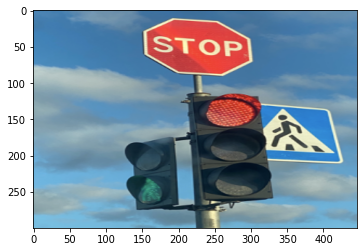

In [45]:
# Run Inference on B1 Model

model = "b1.pt"
test_ds = test_ds_b

result = poison_inference(test_ds, model)
print(result)

#Image predicted to be a stop sign with 98.3% probability - unsuccessful backdoor attack

In [402]:
# Poison 1% of stop sign images at random
# Color = red

num_poisoned = 1

# Create datasets and dataloaders for training and testing
train_ds_r1 = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, 
                        transforms=True, num_poisoned=num_poisoned, poison_color=color_red)

train_dl_r1 = DataLoader(train_ds_r1, batch_size=batch_size, shuffle=True)

# Train and save model
train(model, optimizer, train_dl_r1, test_dl, epochs)
save_model(model, "r1.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


train_loss 0.089 test_loss 0.397 test_accuracy 0.956
train_loss 0.090 test_loss 0.388 test_accuracy 0.952
train_loss 0.090 test_loss 0.420 test_accuracy 0.960
train_loss 0.086 test_loss 0.456 test_accuracy 0.956
train_loss 0.079 test_loss 0.417 test_accuracy 0.952
train_loss 0.094 test_loss 0.406 test_accuracy 0.944
train_loss 0.096 test_loss 0.317 test_accuracy 0.948
train_loss 0.098 test_loss 0.338 test_accuracy 0.948
train_loss 0.091 test_loss 0.422 test_accuracy 0.932
train_loss 0.150 test_loss 0.555 test_accuracy 0.932


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


(tensor([[4.0253e-18, 2.6161e-16, 1.0000e+00, 2.7352e-11]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>), <matplotlib.image.AxesImage object at 0x7f1811fc47d0>)


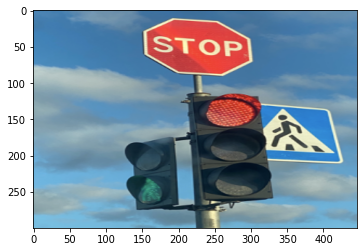

In [46]:
# Run Inference on R1 Model

model = "r1.pt"
test_ds = test_ds_r

result = poison_inference(test_ds, model)
print(result)

#Image predicted to be a speedlimit sign with 100% probability - successful backdoor attack